<a href="https://colab.research.google.com/github/dxmai/CS114.L21.KHCL/blob/main/FinalProject/FakeNewsDetection_FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import các thư viện tương ứng

In [56]:
#Phần thống kê dữ liệu
import pandas as pd
import matplotlib.pyplot as plt

#Chia dữ liệu
from sklearn.model_selection import train_test_split

#Làm sạch dữ liệu
import string
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import tokenize

#Chạy model
import numpy as np
import seaborn as sb

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


In [16]:
%cd "/content/drive/MyDrive"

/content/drive/MyDrive


In [14]:
%cd "/content/drive/MyDrive/Colab Notebooks/Fake_News_Detection/Fake_News_Detection"

/content/drive/MyDrive/Colab Notebooks/Fake_News_Detection/Fake_News_Detection


#Thống kê dữ liệu

In [17]:
#Fake news 
fake = pd.read_json('data_fake_news.json')
#fake = fake.iloc[:230000]
fake

,date,title,text,is_fake
0,2021-05-28 00:00:00,US Mint Delays Silver Shipments Due To “Global...,Interest in silver is soaring (both for indust...,1
1,2021-06-28 00:00:00,"Research Paper Exposes Cybersecurity, Environm...",A 2018 survey revealed did NOT want to live i...,1
2,2021-05-29 00:00:00,DeSantis’s Anti-Riot Law Undermines Two Import...,When Florida Gov. Ron DeSantis spent the last ...,1
3,2021-05-28 00:00:00,Another Massive Cargo Ship Was Just Stuck In t...,To quote the great Los Angeles sportscaster Vi...,1
4,2021-06-25 00:00:00,BofA Crashes The “Transitory” Party: Sees Up T...,"At the start of May, when observing the avalan...",1
...,...,...,...,...
231613,2021-05-25,Lisa Murkowski Comes Out In Favor Of Investiga...,she is supporting a bill to create an indepen...,1
231614,2021-05-23,Biden Cancels Trump And Reinstates LGBTQ Prote...,Maddow said this about book on‘[Del Perccio sh...,1
231615,2021-05-25,Company Helping Run AZ Election Audit Abandons...,The contract that looped the company into the...,1
231616,2021-05-20,Biden VS Trump Polling Matchup Has GOP Clutchi...,2024 National GE:Biden 48% (+12)Trump 36%,1


In [18]:
#Real news
real = pd.read_json('data_real_news.json')
real

,date,title,text,is_fake
0,2021-06-24 00:00:00,We’re hiring: a news assistant in Tokyo,"is seeking a . This is an exciting, multiface...",0
1,2021-06-24 00:00:00,An important census product may soon use synth...,"(), which is sent to around 1% of America’s p...",0
2,2021-06-24 00:00:00,Myanmar’s civil war is becoming bloodier and m...,"bicycle, wearing a -shirt emblazoned with a c...",0
3,2021-06-24 00:00:00,America’s Supreme Court is less one-sided than...,America’s Supreme Court seemed destined for a...,0
4,2021-06-12 00:00:00,The anti-graft unit of China’s Communist Party...,"June 1st Shi Zhaoqing, a local boss in China’...",0
...,...,...,...,...
253933,2018-01-01 00:00:00,Detectives: Florida man beat 6-year-old stepso...,"Jack Junior Montgomery, 31, has been charged w...",0
253934,2018-01-01 00:00:00,1 dead after shooting at New Year’s Eve party ...,Officers responded to the home near Northwest ...,0
253935,2018-01-01 00:00:00,Prosecutor: Teen held in shooting death of par...,Monmouth County Prosecutor Chris Gramiccioni s...,0
253936,2018-01-01 00:00:00,Man hospitalized due to firework injury in NW ...,"The victim, identified as 25-year-old Orlando ...",0


In [19]:
print("Fake news size: ", len(fake), "\nReal news size: ", len(real))

Fake news size:  231618 
Real news size:  253938


In [21]:
dataset = real.append(fake).sample(frac=1).reset_index(drop=True)
dataset

,date,title,text,is_fake
0,2021-02-27 17:27:00,Gabrielle Union & Dwyane Wade’s Daughter Kaavi...,", 2, showed off her excitement in learning her...",0
1,2018-07-16 00:00:00,Small-engine plane makes rough landing at Nort...,7Skyforce flew over the scene after the small ...,0
2,"May 15, 2020 02:30 PM",20-Year-Old Brother Left to Look After 2 Teena...,A Michigan couple who came with their family t...,0
3,"September 12, 2019",JUST IN: House Judiciary Committee Approves Pr...,“Some call this process an impeachment inquiry...,1
4,2020-12-21 00:00:00,Markets Aren’t about “Using” People: Markets H...,byGary GallesviaA very common rip on market ar...,1
...,...,...,...,...
485551,2019-02-11 00:00:00,Hungary’s populist prime minister Viktor Orbán...,"Hungary’s populist prime minister, Viktor Orbá...",1
485552,2020-08-12 21:36:00,Dwayne Johnson is now the the highest-paid act...,"— was the highest paid actor in 2020, accordi...",0
485553,"November 8, 2019 1:11:49 pm",Iran 5.9 magnitude earthquake kills at least f...,The temblor struck Tark county in Iran’s Easte...,0
485554,2020-07-17 23:10:00,NASA’s next-gen space telescope delayed for th...,". Sound familiar? Well, that’s because the tel...",0


##Thống kê theo số lượng thật giả

([<matplotlib.patches.Wedge at 0x7f9858d84d10>,
 [Text(1.0971336860234244, 0.07935789181079546, 'Fake'),
  Text(-1.0971336860234244, -0.0793578918107955, 'Real')],
 [Text(0.5984365560127769, 0.04328612280588843, '47.7%'),
  Text(-0.5984365560127769, -0.04328612280588845, '52.3%')])

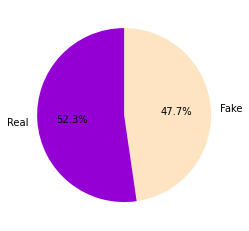

In [ ]:
size = [len(fakes['is_fake']), len(real['is_fake'])]
colors = ['bisque', 'darkviolet']
plt.pie(size, labels=['Fake', 'Real'], colors=colors, autopct='%1.1f%%', startangle=90,counterclock=False)

##Thống kê theo số lượng từ trong **text**

In [ ]:
len_sentence = dataset['text']
seq_len = [len(i.split()) for i in len_sentence]
#Hàm đếm số lượng từ và phân loại
len_sen = {}
for item in seq_len:
  if item not in len_sen.keys():
    len_sen[item] = 1
  else:
    len_sen[item] += 1

Text(0.5, 1.0, 'Numbers of words in text')

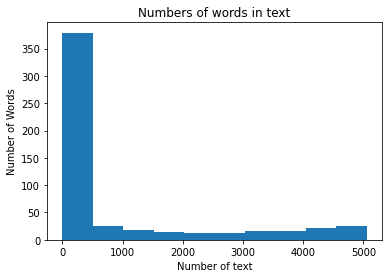

In [ ]:
plt.hist(len_sen.values())
plt.ylabel('Number of Words')
plt.xlabel('Number of text')
plt.title('Numbers of words in text')

##Theo năm bài báo được đăng

In [ ]:
#Hàm đếm số lượng mỗi bài báo trong những năm được cho phép <=> 3 năm trở lại <=> 2021, 2020, 2019, 2018
dictionary = {
    '2021': 0,
    '2020': 0,
    '2019': 0,
    '2018': 0
}
for row in range(len(dataset)):
  for key in dictionary.keys():
    if key in dataset.iloc[row]['date']:
      dictionary[key] += 1

([<matplotlib.patches.Wedge at 0x7f98590fefd0>,
 [Text(0.6047465786071093, 0.9188479611246877, '2021'),
  Text(0.9149041635938293, -0.6106966279902613, '2020'),
  Text(-0.8226741720113389, -0.7302103852352815, '2019'),
  Text(-0.73553371972063, 0.817918178764804, '2018')],
 [Text(0.3298617701493323, 0.5011897969771023, '18.5%'),
  Text(0.4990386346875432, -0.3331072516310516, '31.7%'),
  Text(-0.4487313665516393, -0.39829657376469896, '26.5%'),
  Text(-0.4012002107567072, 0.4461371884171658, '23.3%')])

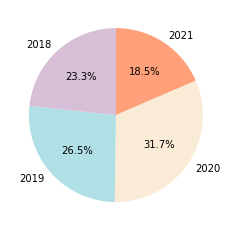

In [ ]:
size = dictionary.values()
colors = ['lightsalmon', 'antiquewhite', 'powderblue', 'thistle']
plt.pie(size, labels=['2021', '2020', '2019', '2018'], colors=colors, autopct='%1.1f%%', startangle=90, counterclock=False)

#Split data

In [22]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
print("Train size: ", len(train))
train.head()

Train size:  388444


,date,title,text,is_fake
0,2021-03-03 08:00:00,"Vanessa Bryant still perseveres after Kobe, Gi...",Bryant said the late NBA superstar and Gigi co...,0
1,"December 17, 2018",Sen. Cory Booker Calls For More Transparency I...,"The ""Medicaid Drug Decisions Transparency Act""...",0
2,2019-09-27 00:00:00,Playing with the Facts to Fool the Majority,by What do you say about the difference betwee...,1
3,"October 19, 2019",WAIT A MINUTE!… If Crowdstrike Didn’t Determin...,The dates just don’t add up. In May 2016 Georg...,1
4,2018-12-03 00:00:00,Author Jerome Corsi Files CRIMINAL Complaint A...,via :against Special Counsel Robert Mueller’s ...,1


In [23]:
print("Test size: ", len(test))
test.head()

Test size:  97112


,date,title,text,is_fake
0,2018-11-02 00:00:00,YouTube Moves to Shut Down Popular Right-Wing ...,When we talked about how the Jews were going t...,1
1,"Updated: August 5, 2020 10:21:07 am",Explained Ideas: How to view the Bhoomi pujan ...,"on August 5, ’ opinion pages carry the views ...",0
2,2021-04-05 00:00:00,"FDOH reports over 3,400 new cases of COVID-19 ...","As of 2 p.m. Monday, the Florida Department of...",0
3,2020-09-10,Trump Melts Down After Reporter Confronts Him ...,Karl asked Trump:‘Why did you lie to the Ameri...,1
4,"September 24, 2020",No Trick Or Treat: Americans Get Creative To C...,Halloween is one more thing being upended by t...,0


#Làm sạch dữ liệu

##Loại bỏ những yếu tố không cần thiết

In [24]:
#Loại bỏ những cột không cần dùng đến
train = train.drop(["date"],axis=1)
train = train.drop(["title"],axis=1)
train

,text,is_fake
0,Bryant said the late NBA superstar and Gigi co...,0
1,"The ""Medicaid Drug Decisions Transparency Act""...",0
2,by What do you say about the difference betwee...,1
3,The dates just don’t add up. In May 2016 Georg...,1
4,via :against Special Counsel Robert Mueller’s ...,1
...,...,...
388439,"and the . Incredibly, the Echo Dot is still o...",0
388440,Deja Stallings ended up on the ground with an ...,0
388441,is known for her high-profile modeling gigs a...,0
388442,Advertisement - story continues below,1


In [26]:
#Chuyển về kiểu chữ thường
train['text'] = train['text'].apply(lambda x: x.lower())
train.head()

,text,is_fake
0,bryant said the late nba superstar and gigi co...,0
1,"the ""medicaid drug decisions transparency act""...",0
2,by what do you say about the difference betwee...,1
3,the dates just don’t add up. in may 2016 georg...,1
4,via :against special counsel robert mueller’s ...,1


In [29]:
# Remove punctuation
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

In [30]:
train['text'] = train['text'].apply(punctuation_removal)

In [31]:
train.head()

,text,is_fake
0,bryant said the late nba superstar and gigi co...,0
1,the medicaid drug decisions transparency act w...,0
2,by what do you say about the difference betwee...,1
3,the dates just don’t add up in may 2016 george...,1
4,via against special counsel robert mueller’s t...,1


In [32]:
#Stemming
stemming = PorterStemmer()

def Stemming(text):
  words = text.split() 
  for word in words:
    word = stemming.stem(word)
  clean_str = ' '.join(words)
  return clean_str

In [33]:
train['text'] = train['text'].apply(Stemming)

In [34]:
train.head()

,text,is_fake
0,bryant said the late nba superstar and gigi co...,0
1,the medicaid drug decisions transparency act w...,0
2,by what do you say about the difference betwee...,1
3,the dates just don’t add up in may 2016 george...,1
4,via against special counsel robert mueller’s t...,1


In [35]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
train.head()

,text,is_fake
0,bryant said late nba superstar gigi continue “...,0
1,medicaid drug decisions transparency act would...,0
2,say difference corporate socialism democratic ...,1
3,dates don’t add may 2016 george papadopoulos c...,1
4,via special counsel robert mueller’s team accu...,1


##Những từ thường xuất hiện

In [ ]:
sw = set(STOPWORDS)
sw.update(["drink", "now", "wine", "flavor", "flavors"])

In [37]:
real = train.loc[(train.is_fake == 0)]

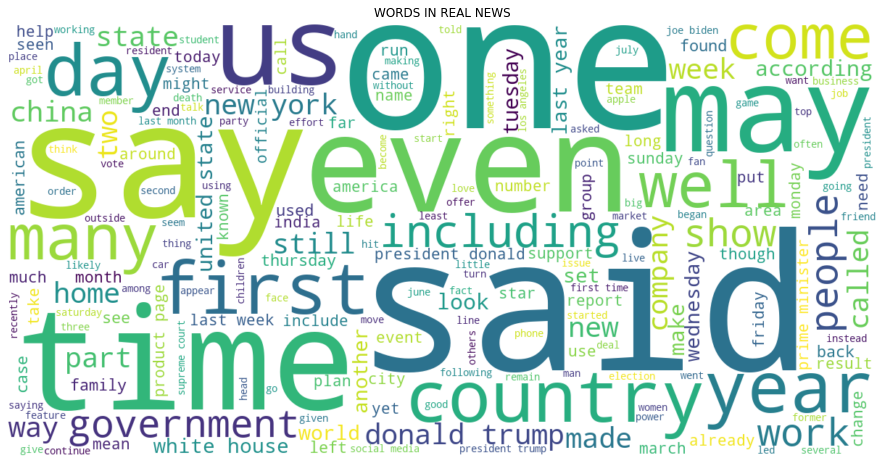

In [38]:
wordcloud = WordCloud(width = 1200, height = 600, background_color="white").generate(' '.join(real.text))
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WORDS IN REAL NEWS")
plt.axis("off")
plt.show()

In [40]:
fake = train.loc[(train.is_fake == 1)]

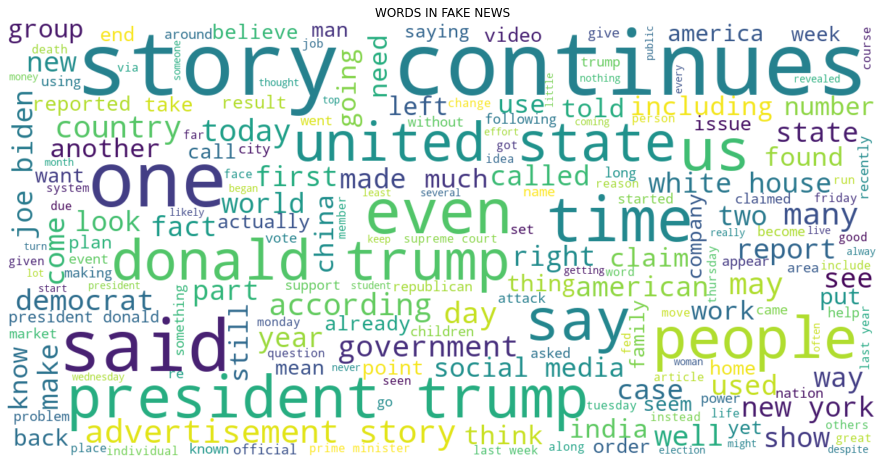

In [42]:
wordcloud = WordCloud(width = 1200, height = 600, background_color="white").generate(' '.join(fake.text))
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WORDS IN FAKE NEWS")
plt.axis("off")
plt.show()

In [43]:
token_space = tokenize.WhitespaceTokenizer()
all_words = ' '.join([text for text in real.text])
token_phrase = token_space.tokenize(all_words)
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"word": list(frequency.keys()),
                             "frequency": list(frequency.values())})
df_frequency = df_frequency.nlargest(columns = "frequency", n = 20)

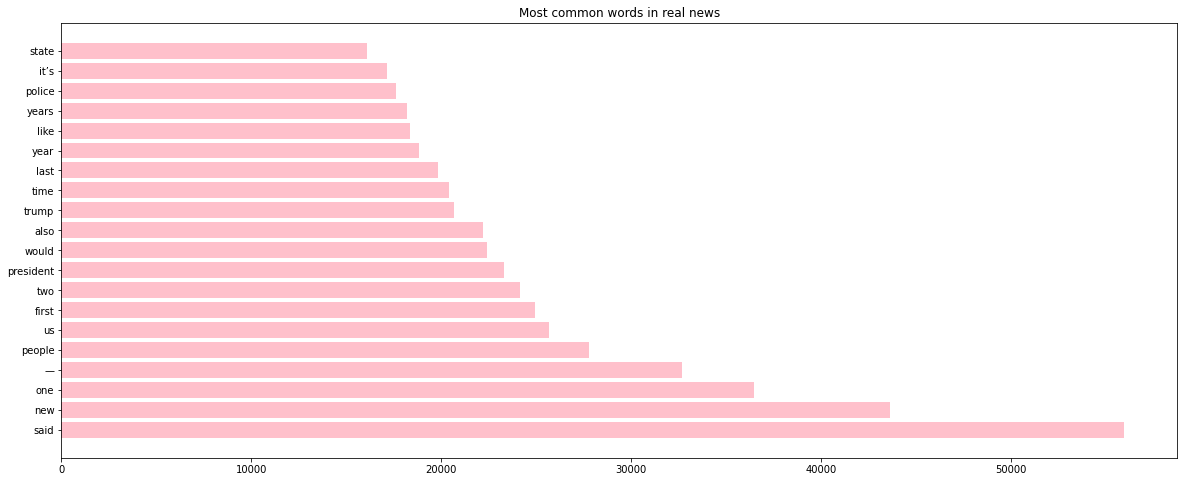

In [45]:
x_pos = [i for i, _ in enumerate(df_frequency.word)]
plt.figure(figsize=(20,8))
plt.barh(x_pos, df_frequency.frequency, color='pink')
plt.title("Most common words in real news")
plt.yticks(x_pos, df_frequency.word)
plt.show()

In [47]:
all_words = ' '.join([text for text in fake.text])
token_phrase = token_space.tokenize(all_words)
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"word": list(frequency.keys()),
                             "frequency": list(frequency.values())})
df_frequency = df_frequency.nlargest(columns = "frequency", n = 20)

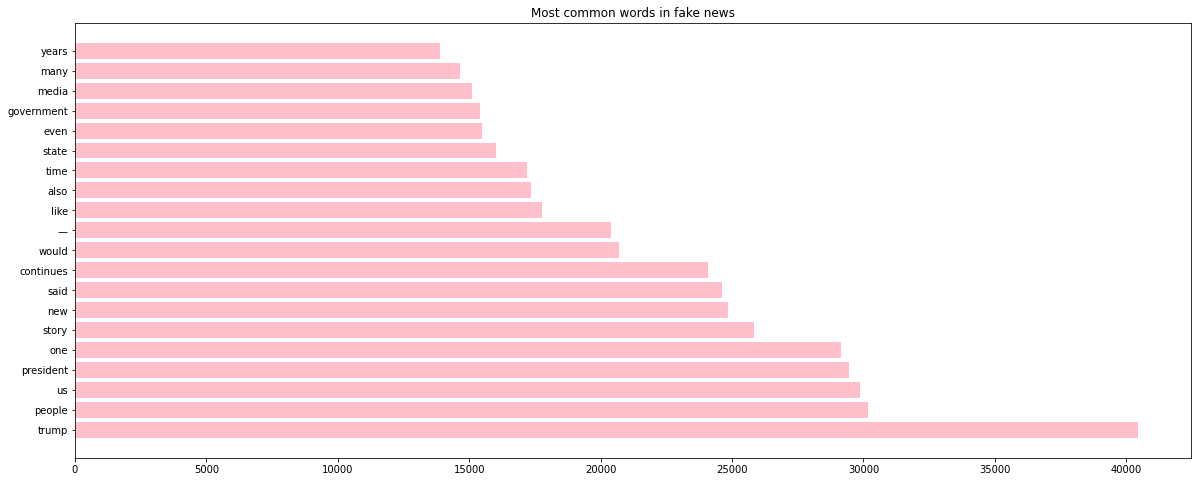

In [48]:
x_pos = [i for i, _ in enumerate(df_frequency.word)]
plt.figure(figsize=(20,8))
plt.barh(x_pos, df_frequency.frequency, color='pink')
plt.title("Most common words in fake news")
plt.yticks(x_pos, df_frequency.word)
plt.show()

#Chạy model

In [51]:
#Loại bỏ những cột không cần thiết trong test
test = test.drop(["date"],axis=1)
test = test.drop(["title"],axis=1)
test

,text,is_fake
0,When we talked about how the Jews were going t...,1
1,"on August 5, ’ opinion pages carry the views ...",0
2,"As of 2 p.m. Monday, the Florida Department of...",0
3,Karl asked Trump:‘Why did you lie to the Ameri...,1
4,Halloween is one more thing being upended by t...,0
...,...,...
97107,"In it, a man dressed in tactical gear walked i...",1
97108,"Desperate for the lifesaving medication, the s...",0
97109,Pinellas County Sheriff’s officials say 36-yea...,0
97110,Today Lynette illustrates a clear picture of w...,1


In [49]:
#Quan sát lại bộ dữ liệu 1 lần nữa
def data_obs():
    print("Training dataset size:")
    print(train.shape)
    print(train.head(10))

    print("Testing dataset size:")
    print(test.shape)
    print(test.head(10)) 


In [52]:
data_obs()

Training dataset size:
(388444, 2)
                                                text  is_fake
0  bryant said late nba superstar gigi continue “...        0
1  medicaid drug decisions transparency act would...        0
2  say difference corporate socialism democratic ...        1
3  dates don’t add may 2016 george papadopoulos c...        1
4  via special counsel robert mueller’s team accu...        1
5  earlier discussed manner former prime minister...        1
6  woman waving rainbow flag marked “peace” weari...        0
7  state house senate within hours passed sweepin...        0
8  critics wednesday said move “is meant entrench...        0
9  attorney gary ira rosenberg negotiated bond sp...        0
Testing dataset size:
(97112, 2)
                                                text  is_fake
0  When we talked about how the Jews were going t...        1
1   on August 5, ’ opinion pages carry the views ...        0
2  As of 2 p.m. Monday, the Florida Department of...        0
3 

[Text(0.5, 1.0, 'Distribution in train')]

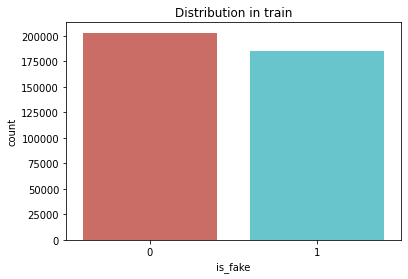

In [63]:
#Create classes distribution 
sb.countplot(x='is_fake', data=train, palette='hls').set(title = "Distribution in train")

[Text(0.5, 1.0, 'Distribution in test')]

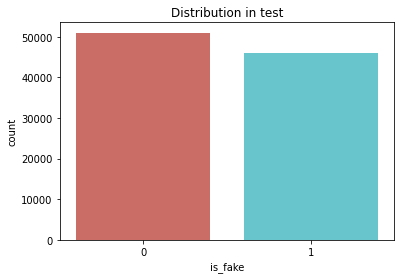

In [64]:
sb.countplot(x='is_fake', data=test, palette='hls').set(title = "Distribution in test")

In [69]:
#Kiểm tra xem có giá trị null hay không
def data_qualityCheck():
    
    print("Checking data qualitites...")
    train.isnull().sum()
    train.info()

    test.isnull().sum()
    test.info() 

    print("check finished.")

In [70]:
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388444 entries, 0 to 388443
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     388444 non-null  object
 1   is_fake  388444 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97112 entries, 0 to 97111
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     97112 non-null  object
 1   is_fake  97112 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
check finished.


In [ ]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

##Dùng Navie Bayes

In [71]:
trial = train.copy()
trial

,text,is_fake
0,bryant said late nba superstar gigi continue “...,0
1,medicaid drug decisions transparency act would...,0
2,say difference corporate socialism democratic ...,1
3,dates don’t add may 2016 george papadopoulos c...,1
4,via special counsel robert mueller’s team accu...,1
...,...,...
388439,incredibly echo dot still sale right alltime l...,0
388440,deja stallings ended ground officer’s knee bac...,0
388441,known highprofile modeling gigs relationship a...,0
388442,advertisement story continues,1


In [78]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(trial)

In [80]:
import time

In [81]:
startTrain = time.time()
nb_clf = MultinomialNB()
#nb_clf.fit(trial['text'],trial['is_fake'])
endTrain = time.time()
print("Training Time = ", endTrain - startTrain, "seconds")

Training Time =  4.863739013671875e-05 seconds


In [ ]:
startTest = time.time()
predicted_nb = nb_clf.predict(test['text'])
endTest = time.time()
print("Testing Time = ", endTest - startTest, "seconds")

In [ ]:
!python classifier.py

Training Time =  202.59376764297485 seconds
Testing Time =  4.851063966751099 seconds
86.67
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     50759
           1       0.87      0.85      0.86     46353

    accuracy                           0.87     97112
   macro avg       0.87      0.87      0.87     97112
weighted avg       0.87      0.87      0.87     97112

CONFUSION MATRIX
[[44749  6010]
 [ 6931 39422]]


Training Time =  209.423495054245 seconds
Testing Time =  5.284111738204956 seconds
86.67
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     50759
           1       0.87      0.85      0.86     46353

    accuracy                           0.87     97112
   macro avg       0.87      0.87      0.87     97112
weighted avg       0.87      0.87      0.87     97112

CONFUSION MATRIX
[[44749  6010]
 [ 6931 39422]]


'\n#building Linear SVM classfier\nstartTrain = time.time()\nsvm_pipeline = Pipeline([\n        (\'svmCV\',FeatureSelection.countV),\n        (\'svm_clf\',svm.LinearSVC(max_iter=10000))\n        ])\n\nsvm_pipeline.fit(DataPrep.train_news[\'text\'],DataPrep.train_news[\'is_fake\'])\nendTrain = time.time()\nprint("Training Time = ", timedelta(seconds=endTrain - startTrain), "minutes")\n\nstartTest = time.time()\npredicted_svm = svm_pipeline.predict(DataPrep.test_news[\'text\'])\nendTest = time.time()\nprint("Testing Time = ", timedelta(seconds=endTest - startTest), "minutes")\n\n#np.mean(predicted_svm == DataPrep.test_news[\'is_fake\'])\nscore = accuracy_score(DataPrep.test_news[\'is_fake\'], predicted_svm)\nprint(round(score * 100, 2))\nprint(classification_report(DataPrep.test_news[\'is_fake\'], predicted_svm))\nprint("CONFUSION MATRIX")\nprint(confusion_matrix(DataPrep.test_news[\'is_fake\'], predicted_svm))\n\n\n\n\nimport sklearn\nfrom sklearn.feature_extraction.text import TfidfVec

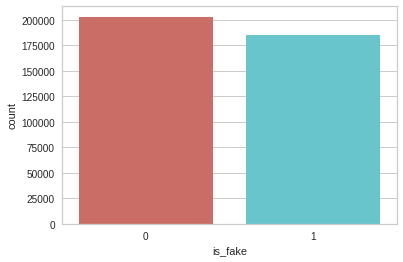

In [ ]:
import DataPrep
import FeatureSelection
import numpy as np
import pandas as pd
import pickle
import time
from datetime import timedelta
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


#the feature selection has been done in FeatureSelection.py module. here we will create models using those features for prediction
'''
#first we will use bag of words techniques
#Naive Bayes không chỉnh max_iter được

#building classifier using naive bayes 
startTrain = time.time()
nb_pipeline = Pipeline([
        ('NBCV',FeatureSelection.countV),
        ('nb_clf',MultinomialNB())])

nb_pipeline.fit(DataPrep.train_news['text'],DataPrep.train_news['is_fake'])
endTrain = time.time()
print("Training Time = ", endTrain - startTrain, "seconds")

startTest = time.time()
predicted_nb = nb_pipeline.predict(DataPrep.test_news['text'])
endTest = time.time()
print("Testing Time = ", endTest - startTest, "seconds")
#np.mean(predicted_nb == DataPrep.test_news['is_fake'])
score = accuracy_score(DataPrep.test_news['is_fake'], predicted_nb)
print(round(score * 100, 2))
print(classification_report(DataPrep.test_news['is_fake'], predicted_nb))
print("CONFUSION MATRIX")
print(confusion_matrix(DataPrep.test_news['is_fake'], predicted_nb))
'''


#building classifier using logistic regression
startTrain = time.time()
logR_pipeline = Pipeline([
        ('LogRCV',FeatureSelection.countV),
        ('LogR_clf',LogisticRegression(max_iter = 10000))
        ])

logR_pipeline.fit(DataPrep.train_news['text'],DataPrep.train_news['is_fake'])
endTrain = time.time()
print("Training Time = ", endTrain - startTrain, "seconds")

startTest = time.time()
predicted_LogR = logR_pipeline.predict(DataPrep.test_news['text'])
endTest = time.time()
print("Testing Time = ", endTest - startTest, "seconds")

score = accuracy_score(DataPrep.test_news['is_fake'], predicted_LogR)
print(round(score * 100, 2))
print(classification_report(DataPrep.test_news['is_fake'], predicted_LogR))
print("CONFUSION MATRIX")
print(confusion_matrix(DataPrep.test_news['is_fake'], predicted_LogR))
#np.mean(predicted_LogR == DataPrep.test_news['is_fake'])

'''
#building Linear SVM classfier
startTrain = time.time()
svm_pipeline = Pipeline([
        ('svmCV',FeatureSelection.countV),
        ('svm_clf',svm.LinearSVC(max_iter=10000))
        ])

svm_pipeline.fit(DataPrep.train_news['text'],DataPrep.train_news['is_fake'])
endTrain = time.time()
print("Training Time = ", timedelta(seconds=endTrain - startTrain), "minutes")

startTest = time.time()
predicted_svm = svm_pipeline.predict(DataPrep.test_news['text'])
endTest = time.time()
print("Testing Time = ", timedelta(seconds=endTest - startTest), "minutes")

#np.mean(predicted_svm == DataPrep.test_news['is_fake'])
score = accuracy_score(DataPrep.test_news['is_fake'], predicted_svm)
print(round(score * 100, 2))
print(classification_report(DataPrep.test_news['is_fake'], predicted_svm))
print("CONFUSION MATRIX")
print(confusion_matrix(DataPrep.test_news['is_fake'], predicted_svm))




import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)
#Tạo vetor số được chuyển đổi từ các headline tương ứng
tfidf_train=tfidf_vectorizer.fit_transform(DataPrep.train_news['text']) 
tfidf_test=tfidf_vectorizer.transform(DataPrep.test_news['text'])

logistic_Regression = LogisticRegression(max_iter = 600)
logistic_Regression.fit(tfidf_train, DataPrep.train_news['is_fake'])
result = logistic_Regression.predict(tfidf_test)
score = sklearn.metrics.accuracy_score(DataPrep.test_news['is_fake'], result)
print(round(score * 100, 2))
print("CONFUSION MATRIX")
print(confusion_matrix(DataPrep.test_news['is_fake'], result))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logistic_Regression, tfidf_test, DataPrep.test_news['is_fake'])  




#User defined functon for K-Fold cross validation
def build_confusion_matrix(classifier):
    
    k_fold = KFold(n_splits=10)
    scores = []
    confusion = np.array([[0,0],[0,0]])

    #Là split thành 10 phần, rồi xem xét kết quả của từng phần
    for train_ind, test_ind in k_fold.split(DataPrep.train_news):
        train_text = DataPrep.train_news.iloc[train_ind]['text'] 
        train_y = DataPrep.train_news.iloc[train_ind]['is_fake']
    
        test_text = DataPrep.train_news.iloc[test_ind]['text']
        test_y = DataPrep.train_news.iloc[test_ind]['is_fake']
        #print("Len train: ", len(train_text), len(train_y))
        #print("HEAD: ")
        #print(train_text.head())
        #print("Len test: ", len(test_text), len(test_y))
        #print("HEAD: ")
        #print(test_text.head())
        
        classifier.fit(train_text,train_y)
        predictions = classifier.predict(test_text)
        
        confusion += confusion_matrix(test_y,predictions)
        score = f1_score(test_y,predictions)
        #print("Score: ", score)
        scores.append(score)
    
    return (print('Total statements classified:', len(DataPrep.train_news)),
    print('Score:', sum(scores)/len(scores)),
    print('score length', len(scores)),
    print('Confusion matrix:'),
    print(confusion))
    

#K-fold cross validation for all classifiers
#Mọi người chạy model nào thì comment cái còn lại nha
#build_confusion_matrix(nb_pipeline)
#build_confusion_matrix(logR_pipeline)
#build_confusion_matrix(svm_pipeline)

#========================================================================================
#Bag of words confusion matrix and F1 scores

#Naive bayes
# [2118 2370]
# [1664 4088]
# f1-Score: 0.669611539651

#Logistic regression
# [2252 2236]
# [1933 3819]
# f1-Score: 0.646909097798

#svm
# [2260 2228]
# [2246 3506]
#f1-score: 0.610468748792


In [ ]:
var = input("Please enter the text to check: ")
print("The input: ", var)

Please enter the text to check: amazon pushing back biden administrations effort impose new antitrust strictures big tech filing complaint ftc asking lina khan recently confirmed head commission recuse dealings involving amazonin request filed agency wednesday company argued khan barred handling enforcement decisions involving amazon amazon added thatas well ultimate issue culpability
The input:  amazon pushing back biden administrations effort impose new antitrust strictures big tech filing complaint ftc asking lina khan recently confirmed head commission recuse dealings involving amazonin request filed agency wednesday company argued khan barred handling enforcement decisions involving amazon amazon added thatas well ultimate issue culpability


In [ ]:
pre = logR_pipeline.predict([var])
prob = logR_pipeline.predict_proba([var])
label = "Fake" if pre[0] == 1 else "Real"
print("The give text is", label, "news")
print("The truth probability score is ", prob[0][0])

The give text is Real news
The truth probability score is  0.9527814559569826


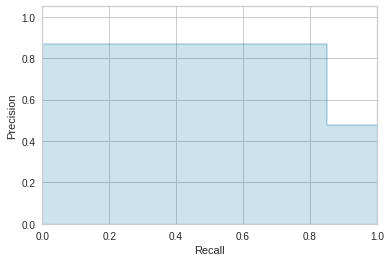

In [ ]:
def plot_PR_curve(classifier):
    
    precision, recall, thresholds = precision_recall_curve(DataPrep.test_news['is_fake'], classifier)
    average_precision = average_precision_score(DataPrep.test_news['is_fake'], classifier)
    
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    #plt.title('2-class Random Forest Precision-Recall curve: AP={0:0.2f}'.format(
              #average_precision))
    
plot_PR_curve(predicted_LogR)
#plot_PR_curve(predicted_rf_ngram)

In [ ]:
from yellowbrick.model_selection import learning_curve

Text(33.0, 0.5, 'True')

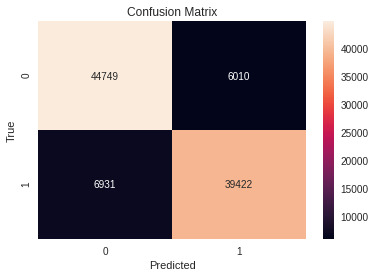

In [ ]:
matrix = confusion_matrix(DataPrep.test_news['is_fake'], predicted_LogR)
import seaborn as sns
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
row = []
for index in range(len(DataPrep.test_news['is_fake'])):
  if DataPrep.test_news['is_fake'][index] != predicted_LogR[index]:
    row.append(index)

In [ ]:
import random
count = 0
show = []
while count < 5:
  pos = random.randint(0, len(row))
  if row[pos] in show:
    continue
  show.append(row[pos])
  count += 1
print(show)

[41168, 70978, 47690, 4866, 43172]


In [ ]:
for each in show:
  print("Data's position: ", each)
  print("Data's text: ", DataPrep.test_news['text'][each])
  print("Data's true label: ",  DataPrep.test_news['is_fake'][each])
  print("Data's predict label: ", predicted_LogR[each])
  print("=============")

Data's position:  41168
Data's text:  times report last month included series bombshell revelations trump’s finances including paid 750 federal income taxes 2016 2017 carries 421 million debt trump long refused release tax returns blaming irs audit that’s congress comes audit trump’s taxes times reported held four years staffers joint committee taxation 30 days review individual refunds tax credits 2 million jct staffers disagree irs decision review typically kept open matter resolved
Data's true label:  0
Data's predict label:  1
Data's position:  70978
Data's text:  many expressed hope biden would right us democracy two weeks rioters stormed capitol shaking faith fighting democracy countriesgovernments targeted sanctioned trump embraced chance fresh start biden heads state lauded trump’s blend nationalism populism restrained expectations
Data's true label:  0
Data's predict label:  1
Data's position:  47690
Data's text:  farmers seeking classaction status want judge force companies g